In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, export_text

# diferentes tipos de experimentos
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

# métricas para avaliação da classificação
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.calibration import calibration_curve

import time

In [2]:
PATH = '../data/data.csv'
PATH_BALANCED = '../data/data_balanced.csv'
MODEL_PATH = '../decision_tree.pkl'

X = 1
O = -1
BLANK = 0

O_WIN   = 0
DRAW    = 1
ONGOING = 2
X_WIN   = 3

In [3]:
df = pd.read_csv(PATH)
df.sample(10)

,0,1,2,3,4,5,6,7,8,category
292,1,0,0,0,1,-1,0,-1,1,3
1031,-1,-1,-1,0,0,0,1,1,0,0
581,0,-1,0,1,-1,-1,1,1,1,3
1290,1,-1,1,1,1,-1,-1,-1,-1,0
1553,0,0,-1,1,1,-1,-1,1,-1,0
89,1,1,-1,-1,1,-1,0,1,0,3
1717,1,-1,-1,1,1,0,1,-1,-1,3
1574,0,0,1,0,1,0,-1,-1,-1,0
2513,1,-1,1,-1,1,1,-1,-1,0,2
1582,-1,-1,1,-1,-1,1,1,0,1,3


In [4]:
feature_cols = [str(i) for i in range(9)]
X = df[feature_cols]


y = df['category']

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [6]:
# 1. Definindo modelo base
model = DecisionTreeClassifier(random_state=42)

# 2. Grade de hiperparâmetros
grid_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10]
}

# 3. Configurar validação cruzada estratificada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Grid Search com F1-score ponderado
grid_search = GridSearchCV(
    model,
    grid_params,
    scoring='f1_weighted',
    cv=skf,
    verbose=3,
    n_jobs=-1,
    return_train_score=True
)

# 5) Treinar e selecionar melhores hiperparâmetros
train_start = time.time()
model_grid = grid_search.fit(X_train, y_train)
train_end = time.time()

Fitting 5 folds for each of 30 candidates, totalling 150 fits


Melhores Hiperparâmetros={'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 2}
Melhor F1=0.8805102411458524
Tempo de Indução: 2.3578720092773438 segundos


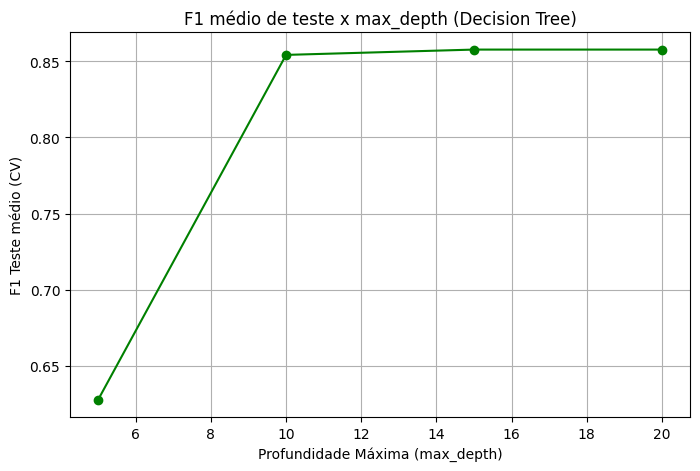

   param_criterion param_max_depth  param_min_samples_split  mean_test_score
24         entropy              20                        2         0.880510
21         entropy              15                        2         0.880510
27         entropy            None                        2         0.880510
12            gini            None                        2         0.879534
9             gini              20                        2         0.879534
6             gini              15                        2         0.879534
18         entropy              10                        2         0.875402
3             gini              10                        2         0.871441
25         entropy              20                        5         0.866095
22         entropy              15                        5         0.866095
28         entropy            None                        5         0.866095
19         entropy              10                        5         0.863599

In [14]:
print('Melhores Hiperparâmetros='+str(model_grid.best_params_))
print('Melhor F1=' + str(model_grid.best_score_))
print(f"Tempo de Indução: {train_end-train_start} segundos")
results = pd.DataFrame(model_grid.cv_results_)

# Agrupa por max_depth e calcula média do mean_test_score
agg_dt = (results
          .groupby('param_max_depth')['mean_test_score']
          .mean()
          .reset_index())

plt.figure(figsize=(8, 5))
plt.plot(agg_dt['param_max_depth'], agg_dt['mean_test_score'], marker='o', color='green')
plt.xlabel('Profundidade Máxima (max_depth)')
plt.ylabel('F1 Teste médio (CV)')
plt.title('F1 médio de teste x max_depth (Decision Tree)')
plt.grid(True)
plt.show()

print(results[['param_criterion', 'param_max_depth', 'param_min_samples_split', 'mean_test_score']]
      .sort_values(by='mean_test_score', ascending=False)
      .head(15))

========== MÉTRICAS ==========
Acurácia = 0.8692307692307693
F1 Score = 0.8676896953420062
Tempo de Execução de Testes = 0.0014 segundos
========== ANÁLISE DE RESULTADOS ==========


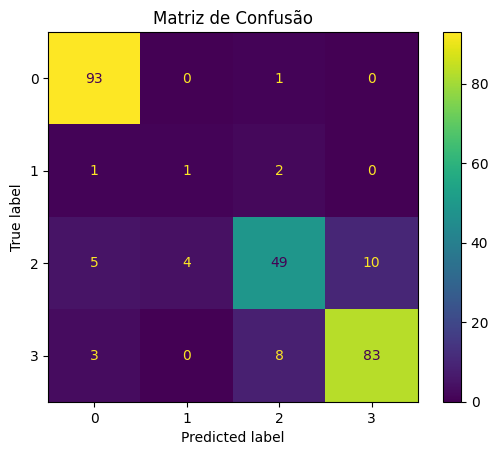

Curva ROC e Curva de Calibração não são geradas automaticamente para múltiplas classes.


In [15]:
import numpy as np

# 1) Medir tempo de previsão no conjunto de teste
test_start = time.time()
pred = model_grid.predict(X_test)
test_end = time.time()

# 2) Calcular e exibir métricas de classificação
print(10 * '=' + ' MÉTRICAS ' + 10 * '=')
print('Acurácia =', accuracy_score(y_test, pred))
print('F1 Score =', f1_score(y_test, pred, average='weighted'))  # usar 'weighted' para múltiplas classes
print(f"Tempo de Execução de Testes = {test_end - test_start:.4f} segundos")

print(10 * '=' + ' ANÁLISE DE RESULTADOS ' + 10 * '=')

# 4) Plotar matriz de confusão
classes = np.unique(y_test)
# Se desejar, pode personalizar os rótulos abaixo com base nas suas classes
# display_labels = ['Classe 0', 'Classe 1', 'Classe 2', ...]
display_labels = classes
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, pred), display_labels=display_labels)
cm_display.plot()
plt.title("Matriz de Confusão")
plt.show()

# 5) Plotar curva ROC (somente se for binário)
if len(classes) == 2:
    pred_probability = model_grid.predict_proba(X_test)
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, pred_probability[:, 1])  # somente para classe positiva
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.figure()
    plt.plot(false_positive_rate, true_positive_rate, label=f"Área sob a Curva ROC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # linha de referência
    plt.xlabel("Taxa de Falsos Positivos")
    plt.ylabel("Taxa de Verdadeiros Positivos")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.show()

    # 6) Avaliar calibração (apenas binário)
    prob_true, prob_pred = calibration_curve(y_test, pred_probability[:, 1], n_bins=10)

    plt.figure()
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("Probabilidade média prevista")
    plt.ylabel("Fração real de positivos")
    plt.title("Curva de Calibração")
    plt.show()
else:
    print("Curva ROC e Curva de Calibração não são geradas automaticamente para múltiplas classes.")